In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torchvision
import timm
import kornia
from torch.utils.data import DataLoader
from tqdm import tqdm


class NormalizedModel(torch.nn.Module):

    def __init__(self, model, mean, std):
        super(NormalizedModel, self).__init__()
        self.model = model
        self.mean = torch.nn.Parameter(torch.Tensor(mean).view(-1, 1, 1), requires_grad=False)
        self.std = torch.nn.Parameter(torch.Tensor(std).view(-1, 1, 1), requires_grad=False)

    def forward(self, x):
        out = (x - self.mean) / self.std 
        out = self.model(out)
        return out

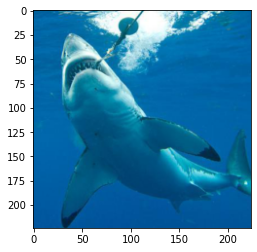

In [2]:
dataset = torchvision.datasets.ImageNet("/workspace/data/datasets/imagenet/", 
                                        split="val", 
                                        transform=torchvision.transforms.Compose(
                                            [
                                                torchvision.transforms.Resize(256), 
                                                torchvision.transforms.CenterCrop(224), 
                                                torchvision.transforms.ToTensor()
                                            ]
                                        )
                                       )

idx = 100
plt.imshow(dataset[idx][0].permute(1, 2, 0).detach().cpu().numpy())

In [7]:
model = timm.create_model("resnet50", pretrained=True)
model = NormalizedModel(model, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
model.cpu()
model.eval()
pass

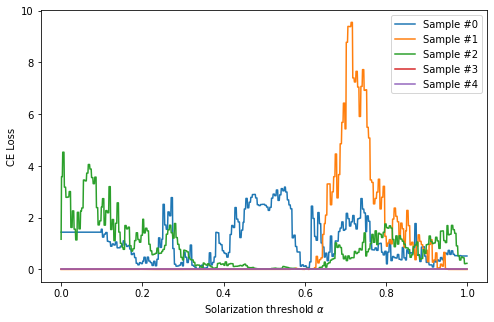

In [8]:
def test(xadv, y):
    logits = model(xadv)
    acc = (logits.argmax(dim=1) == y).float().mean().item()
    return criterion(logits, y).item()

plt.figure(figsize=(8, 5))
criterion = torch.nn.CrossEntropyLoss()

for idx in range(5):

    x = dataset[idx][0].unsqueeze(0).cpu()
    y = torch.tensor([dataset[idx][1]]).cpu()

    steps = np.arange(0, 1, .001)

    with torch.no_grad():
        vals = [test(kornia.enhance.solarize(x, torch.tensor(alpha).float().cpu()), y) for alpha in steps]
        
    plt.plot(steps, vals, label=f"Sample #{idx}")
    
plt.legend()
plt.ylabel("CE Loss")
plt.xlabel(r"Solarization threshold $\alpha$")

plt.savefig('output/imagenet_loss_landscape.pdf', bbox_inches='tight', pad_inches=0.01)